**Game logic**

In [3]:
import numpy as np

def life_step(X):
    live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (live_neighbors == 3) | (X & (live_neighbors == 2)).astype(int)

**Generate Game Boards**

In [4]:
import matplotlib.pyplot as plt

board_shape = (20, 20)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.15

def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

def render_frames(frame1, frame2):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')

frames = generate_frames(10, board_shape=board_shape, prob_alive=probability_alive)
print(frames.shape) # (num_frames, board_w, board_h)

(10, 20, 20)


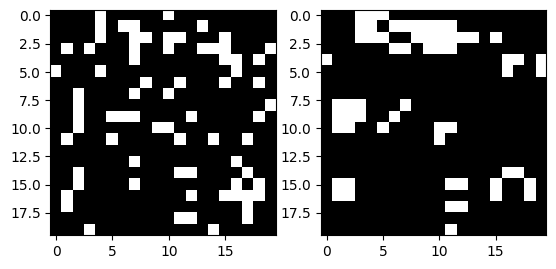

In [5]:
render_frames(frames[1], life_step(frames[1]))

In [6]:
def reshape_input(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

def generate_dataset(num_frames, board_shape, prob_alive):
    X = generate_frames(num_frames, board_shape=board_shape, prob_alive=prob_alive)
    X = reshape_input(X)
    y = np.array([
        life_step(frame)
        for frame in X
    ])
    return X, y

train_size = 70000
val_size   = 10000
test_size  = 20000

In [7]:
print("Training Set:")
X_train, y_train = generate_dataset(train_size, board_shape, probability_alive)
print(X_train.shape)
print(y_train.shape)

Training Set:
(70000, 20, 20, 1)
(70000, 20, 20, 1)


In [8]:
print("Validation Set:")
X_val, y_val = generate_dataset(val_size, board_shape, probability_alive)
print(X_val.shape)
print(y_val.shape)

Validation Set:
(10000, 20, 20, 1)
(10000, 20, 20, 1)


In [9]:
print("Test Set:")
X_test, y_test = generate_dataset(test_size, board_shape, probability_alive)
print(X_test.shape)
print(y_test.shape)

Test Set:
(20000, 20, 20, 1)
(20000, 20, 20, 1)


**Build a Convolutional Neural Network**


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D

# CNN Properties
filters = 50
kernel_size = (3, 3) # look at all 8 neighboring cells, plus itself
strides = 1
hidden_dims = 100

model = Sequential()
model.add(Conv2D(
    filters,
    kernel_size,
    padding='same',
    activation='relu',
    strides=strides,
    input_shape=(board_shape[0], board_shape[1], 1)
))
model.add(Dense(hidden_dims))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 20, 50)        500       
                                                                 
 dense_3 (Dense)             (None, 20, 20, 100)       5100      
                                                                 
 dense_4 (Dense)             (None, 20, 20, 1)         101       
                                                                 
 activation (Activation)     (None, 20, 20, 1)         0         
                                                                 
Total params: 5701 (22.27 KB)
Trainable params: 5701 (22.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
def train(model, X_train, y_train, X_val, y_val, batch_size=50, epochs=5, filename_suffix=''):
    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val)
    )


train(model, X_train, y_train, X_val, y_val, filename_suffix='_basic')

Epoch 1/5
1400/1400 [==============================] - 47s 33ms/step - loss: 0.1321 - accuracy: 0.9635 - val_loss: 0.0826 - val_accuracy: 0.9815
Epoch 2/5
1400/1400 [==============================] - 45s 32ms/step - loss: 0.0812 - accuracy: 0.9817 - val_loss: 0.0819 - val_accuracy: 0.9815
Epoch 3/5
1400/1400 [==============================] - 44s 31ms/step - loss: 0.0810 - accuracy: 0.9817 - val_loss: 0.0816 - val_accuracy: 0.9815
Epoch 4/5
1400/1400 [==============================] - 45s 32ms/step - loss: 0.0809 - accuracy: 0.9817 - val_loss: 0.0817 - val_accuracy: 0.9815
Epoch 5/5
1400/1400 [==============================] - 44s 31ms/step - loss: 0.0809 - accuracy: 0.9817 - val_loss: 0.0816 - val_accuracy: 0.9815


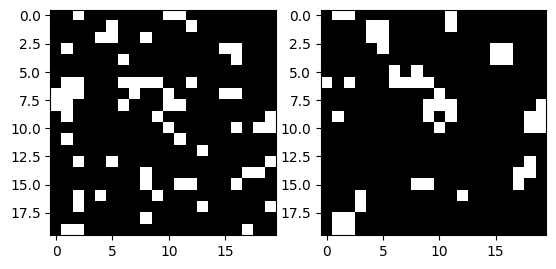

In [10]:
X, y = generate_dataset(1, board_shape=board_shape, prob_alive=probability_alive)

render_frames(X[0].flatten().reshape(board_shape), y)

In [37]:
# Make predictions on a sample dataset, similar to how you generate your training set
pred_probabilities = model.predict(X)

# Since the output and labels are both (1, 20, 20, 1), squeeze out the singleton dimensions
pred_classes = np.squeeze(pred_probabilities)  # This results in (20, 20)
y_classes = np.squeeze(y)  # This also results in (20, 20)

# Assuming the model outputs a continuous range that needs to be thresholded to get binary classes:
threshold = 0.5
pred_classes = (pred_classes > threshold).astype(int)  # Convert to binary classes

# Calculate discrepancies
incorrect_cells = np.count_nonzero(pred_classes != y_classes)
print(incorrect_cells, "incorrect cells.")


1/1 [==============================] - 0s 154ms/step
10 incorrect cells.


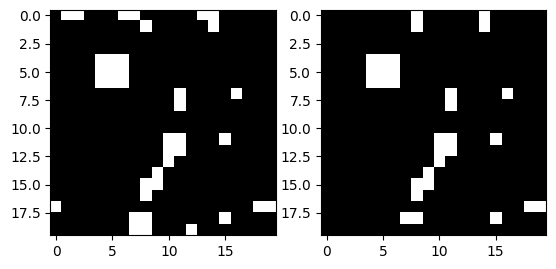

In [38]:
render_frames(y, pred_classes.flatten().reshape(board_shape))

In [ ]:
print(pred_classes.flatten().reshape(board_shape) - y.flatten().reshape(board_shape))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [39]:
model_save_path = './keras_model'
model.save(model_save_path)

In [40]:
!pip install tf2onnx
!pip install onnxruntime
import tensorflow as tf
import tf2onnx

input_spec = [tf.TensorSpec([None, board_shape[0], board_shape[1], 1], tf.float32, name='input')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_spec, opset=12)  # Try different opset versions

In [41]:
# Save the ONNX model to disk
onnx_model_path = 'conway_game_of_life.onnx'
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# !pip install netron
# !pip install graphviz

# import netron
# netron.start('/content/conway_game_of_life.onnx')


!pip install -q netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('/content/conway_game_of_life.onnx', port, browse=False)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

In [1]:
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# Assuming pred_classes now contains binary predictions, similar to the direct TensorFlow model predictions
def apply_threshold(predictions, threshold=0.5):
    """Apply a binary threshold to sigmoid outputs to convert them to 0 or 1."""
    return (predictions > threshold).astype(int)

# Load the ONNX model
sess = ort.InferenceSession("conway_game_of_life.onnx")

# Prepare the input. Make sure it is in the right shape and type.
input_name = sess.get_inputs()[0].name
X_onnx = X_test.astype(np.float32)  # Assuming X_test is your test data array

# Run the model using ONNX runtime
output_name = sess.get_outputs()[0].name
pred_onnx = sess.run([output_name], {input_name: X_onnx})[0]

# Apply threshold to convert probabilities to binary values (0 or 1)
pred_classes = apply_threshold(pred_onnx)

NameError: name 'X_test' is not defined

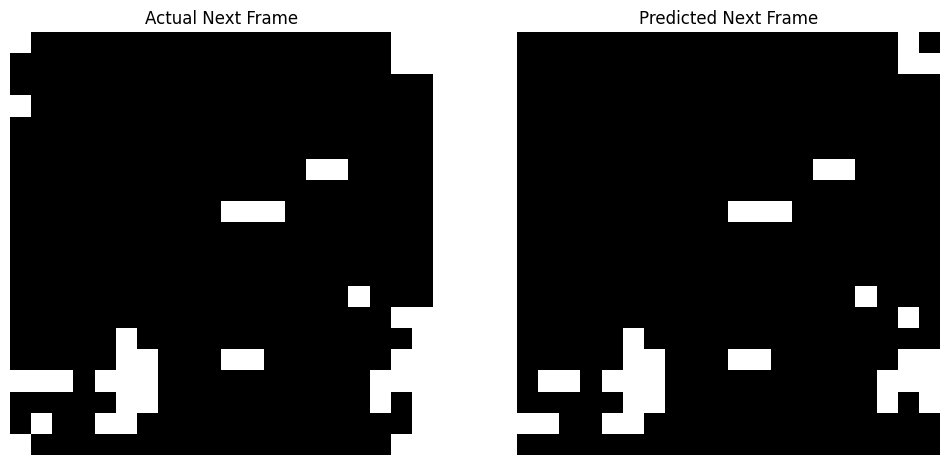

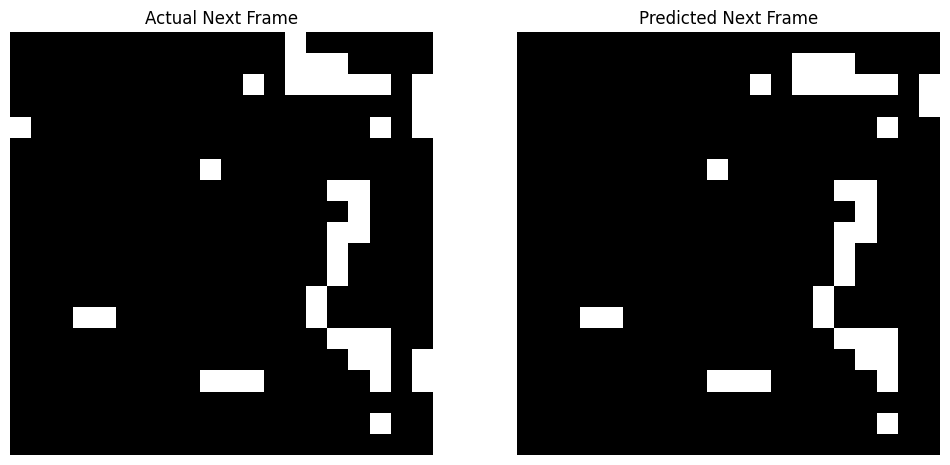

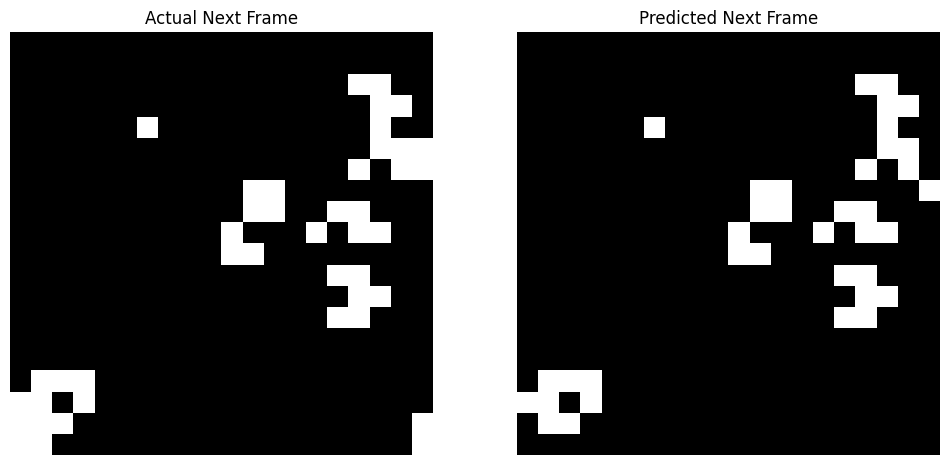

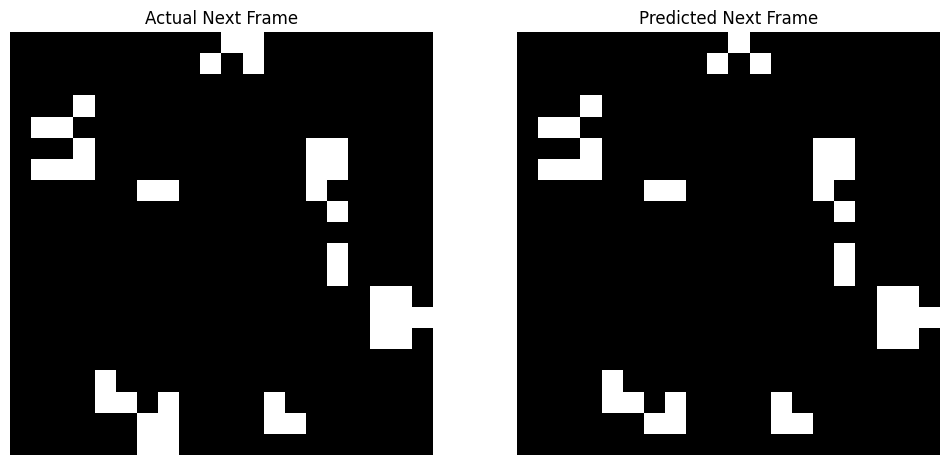

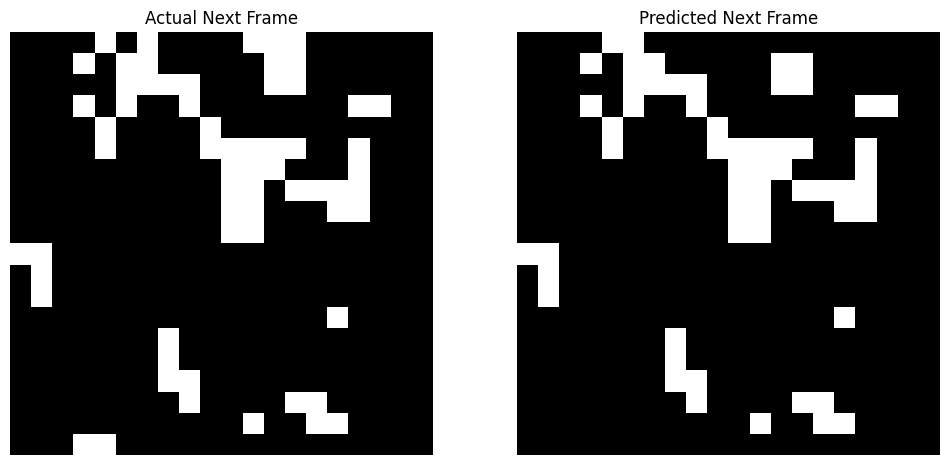

In [ ]:
def render_frames(actual, predicted):
    """Helper function to display two frames side by side: Actual and Predicted"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Actual Next Frame")
    plt.imshow(actual, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Next Frame")
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')

    plt.show()

for i in range(min(5, len(X_test))):  # Visualizing a few examples
    actual_board = y_test[i].reshape(board_shape)
    predicted_board = pred_classes[i].reshape(board_shape)
    render_frames(actual_board, predicted_board)

In [ ]:
import numpy as np
from scipy import signal
from onnx import numpy_helper
import onnx

# Load ONNX model
model_path = 'conway_game_of_life.onnx'  # Adjust the path as needed
model = onnx.load(model_path)
graph = model.graph

# Load weights and biases into dictionaries
weights = {}
biases = {}
for initializer in graph.initializer:
    array = numpy_helper.to_array(initializer)
    if 'bias' in initializer.name.lower():
        biases[initializer.name] = array
    else:
        weights[initializer.name] = array

# Define convolution function
def conv2d(input_tensor, kernel, bias=None, stride=1, padding='valid'):
    num_filters = kernel.shape[3]
    output_height = input_tensor.shape[0] - kernel.shape[0] + 1
    output_width = input_tensor.shape[1] - kernel.shape[1] + 1
    conv_output = np.zeros((output_height, output_width, num_filters))

    for f in range(num_filters):
        # Perform convolution
        conv_output[:, :, f] = signal.correlate2d(input_tensor[:, :, 0], kernel[:, :, 0, f], mode=padding)
        # Add bias if provided
        if bias is not None:
            conv_output[:, :, f] += bias[f]

    return conv_output

# Define ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define dense layer function
def dense(input_tensor, weights, bias):
    return np.dot(input_tensor, weights) + bias

# Example input (initializing with a sample input)
input_tensor = np.random.rand(20, 20, 1)  # Example input tensor shape [height, width, channels]

# First Convolutional Layer
conv1_weights = weights['sequential/conv2d/Conv2D/ReadVariableOp:0'].reshape(3, 3, 1, 50)  # Correct reshaping
conv1_bias = biases['sequential/conv2d/BiasAdd/ReadVariableOp:0']
conv1_output = conv2d(input_tensor, conv1_weights, conv1_bias)
conv1_output = relu(conv1_output)  # Apply ReLU activation

# Flatten output from Conv layer to feed into Dense layer
conv1_flattened = conv1_output.reshape(-1)  # Flatten the output

# First Dense Layer
dense1_weights = weights['sequential/dense/Tensordot/ReadVariableOp:0']
dense1_bias = biases['sequential/dense/BiasAdd/ReadVariableOp:0']
dense1_output = dense(conv1_flattened, dense1_weights, dense1_bias)
dense1_output = relu(dense1_output)  # Applying ReLU activation

# Second Dense Layer
dense2_weights = weights['sequential/dense_1/Tensordot/ReadVariableOp:0']
dense2_bias = biases['sequential/dense_1/BiasAdd/ReadVariableOp:0']
dense2_output = dense(dense1_output, dense2_weights, dense2_bias)
final_output = sigmoid(dense2_output)  # Sigmoid activation for final output

# Output the result
print("Final output from custom runtime: ", final_output)

ValueError: shapes (16200,) and (50,100) not aligned: 16200 (dim 0) != 50 (dim 0)

In [11]:
import onnx

# Load the ONNX model
model_path = '/content/conway_game_of_life.onnx'
model = onnx.load(model_path)

# Print all initializers (weights and biases usually reside here)
print("Initializers in the ONNX model:")
for init in model.graph.initializer:
    print(init.name)

Initializers in the ONNX model:
sequential_3/dense_4/Tensordot/Reshape_shape__68
sequential_3/dense_4/Tensordot/ReadVariableOp:0
sequential_3/dense_4/Tensordot/Const_2:0
sequential_3/dense_4/BiasAdd/ReadVariableOp:0
sequential_3/dense_3/Tensordot/free:0
sequential_3/dense_3/Tensordot/axes:0
sequential_3/dense_3/Tensordot/ReadVariableOp:0
sequential_3/dense_3/Tensordot/Const_2:0
sequential_3/dense_3/BiasAdd/ReadVariableOp:0
sequential_3/conv2d_2/Conv2D/ReadVariableOp:0
sequential_3/conv2d_2/BiasAdd/ReadVariableOp:0
new_shape__67
Const__65


In [12]:
import onnx
from onnx import numpy_helper

# Load the ONNX model
model_path = '/content/conway_game_of_life.onnx'# Update this path to your actual ONNX model file
model = onnx.load(model_path)

# Initialize variables for weights and biases
weights = None
bias = None

# Extract weights and biases based on their names
for init in model.graph.initializer:
    if init.name == "sequential_3/conv2d_2/Conv2D/ReadVariableOp:0":
        weights = numpy_helper.to_array(init)
    elif init.name == "sequential_3/conv2d_2/BiasAdd/ReadVariableOp:0":
        bias = numpy_helper.to_array(init)

# Ensure weights and biases were loaded
assert weights is not None and bias is not None, "Failed to load weights and/or bias."

# Check the shapes of the loaded weights and biases
print("Weights loaded successfully, shape:", weights.shape)
print("Bias loaded successfully, shape:", bias.shape)


Weights loaded successfully, shape: (50, 1, 3, 3)
Bias loaded successfully, shape: (50,)


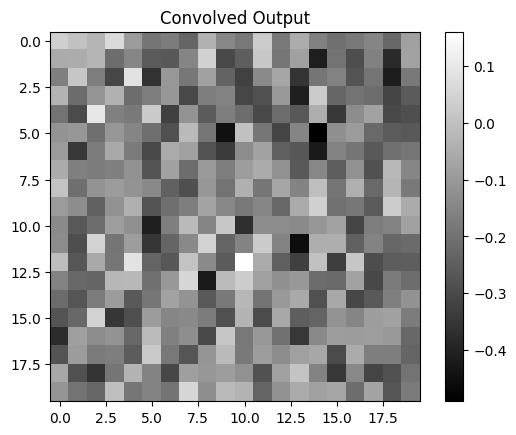

In [33]:
import numpy as np
import onnx
from onnx import numpy_helper
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Load the ONNX model
model_path = '/content/conway_game_of_life.onnx'# Update this path to your actual ONNX model file
model = onnx.load(model_path)

# Initialize variables for weights and biases
weights = None
bias = None

# Extract weights and biases based on their names
for init in model.graph.initializer:
    if init.name == "sequential_3/conv2d_2/Conv2D/ReadVariableOp:0":
        weights = numpy_helper.to_array(init)
    elif init.name == "sequential_3/conv2d_2/BiasAdd/ReadVariableOp:0":
        bias = numpy_helper.to_array(init)

# Ensure weights and biases were loaded
assert weights is not None and bias is not None, "Failed to load weights and/or bias."

def manual_convolution(input_data, weights, bias):
    num_filters = weights.shape[0]
    filter_height, filter_width = weights.shape[2], weights.shape[3]
    batch_size, in_height, in_width, in_channels = input_data.shape

    # Calculate the padding needed to achieve 'same' convolution output size
    pad_height = max(0, (in_height - 1) * 1 + filter_height - in_height) // 2
    pad_width = max(0, (in_width - 1) * 1 + filter_width - in_width) // 2

    # Pad the input array
    padded_input = np.pad(input_data, ((0, 0), (pad_height, pad_height), (pad_width, pad_width), (0, 0)), 'constant', constant_values=(0, 0))

    # Initialize the output array to store convolution results
    output = np.zeros((batch_size, in_height, in_width, num_filters))

    for b in range(batch_size):  # Batch size loop
        for f in range(num_filters):  # Filter loop
            for c in range(in_channels):  # Channel loop
                # Apply convolution
                full_conv = convolve2d(padded_input[b, :, :, c], weights[f, c, :, :], mode='full')
                # Crop to maintain the same output size
                crop_start = (full_conv.shape[0] - in_height) // 2
                crop_end = crop_start + in_height
                conv_output = full_conv[crop_start:crop_end, crop_start:crop_end]
                output[b, :, :, f] += conv_output

            # Add bias
            output[b, :, :, f] += bias[f]

    return output[:, :, :, 0]  # Simplifying to return the first filter's output for all examples

# Example usage:
input_data = np.random.rand(1, 20, 20, 1)  # Example input data, 1 example of 20x20 size
convolved_output = manual_convolution(input_data, weights, bias)

# Display results
plt.imshow(convolved_output[0], cmap='gray')
plt.title("Convolved Output")
plt.colorbar()
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def manual_convolution(input_data, weights, bias):
    num_filters = weights.shape[0]
    filter_height, filter_width = weights.shape[2], weights.shape[3]
    batch_size, in_height, in_width, in_channels = input_data.shape

    # Calculate necessary padding to maintain 'same' output size
    padding_height = (filter_height - 1) // 2
    padding_width = (filter_width - 1) // 2

    # Pad input to maintain output size
    padded_input = np.pad(input_data,
                          ((0, 0), (padding_height, padding_height), (padding_width, padding_width), (0, 0)),
                          mode='constant', constant_values=0)

    output = np.zeros((batch_size, in_height, in_width, num_filters))

    for b in range(batch_size):  # Process each item in the batch
        for f in range(num_filters):  # Process each filter
            for c in range(in_channels):  # Process each channel
                # Perform convolution
                full_conv = convolve2d(padded_input[b, :, :, c], weights[f, c, :, :], mode='full')
                # Calculate start indices for cropping
                start_row = (full_conv.shape[0] - in_height) // 2
                start_col = (full_conv.shape[1] - in_width) // 2
                # Crop to match the input size
                conv_output = full_conv[start_row:start_row+in_height, start_col:start_col+in_width]
                output[b, :, :, f] += conv_output

            # Add bias to each filter's output
            output[b, :, :, f] += bias[f]

    return output[:, :, :, 0]  # Returning first filter's output for simplicity

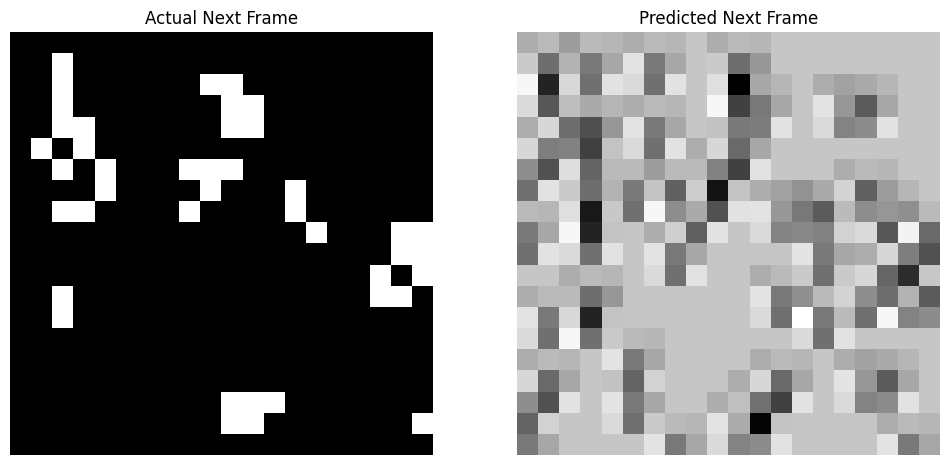

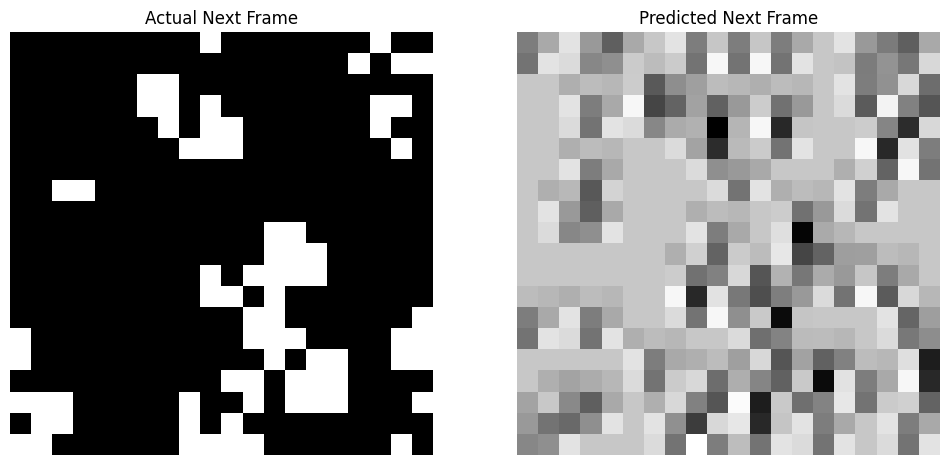

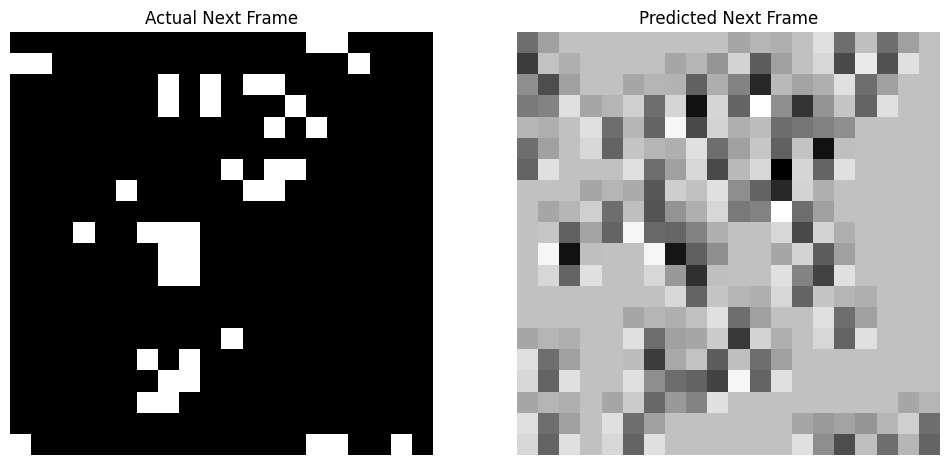

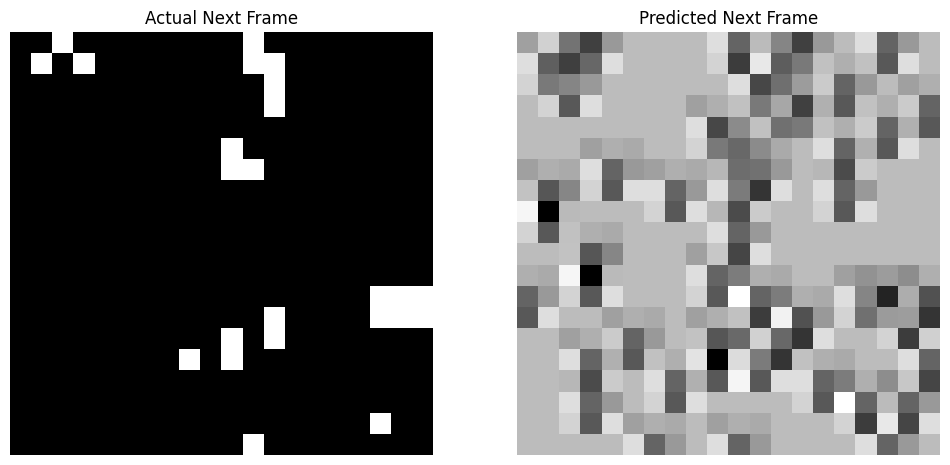

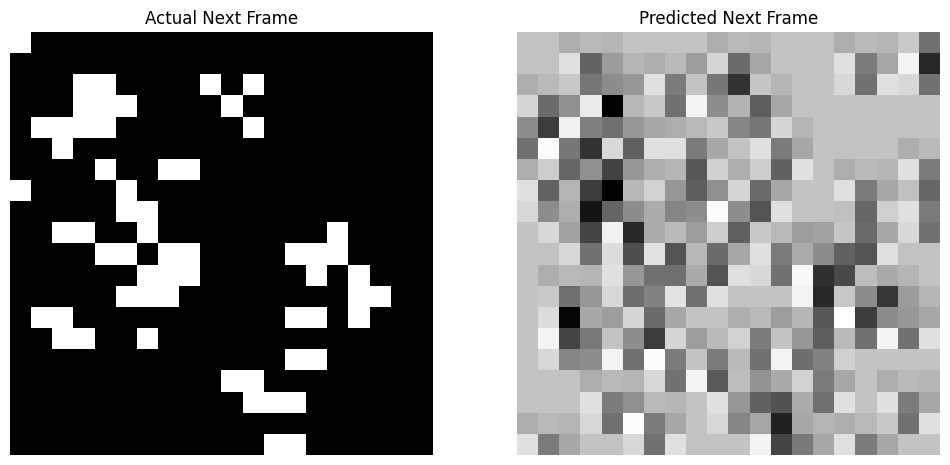

In [38]:
# Assuming the output needs to match (20, 20) board shape
board_shape = (20, 20)

# Apply convolution to the input dataset
pred_classes = [manual_convolution(X_test[i:i+1], weights, bias)[0] for i in range(len(X_test))]

# Display the actual and predicted boards
for i in range(min(5, len(X_test))):
    actual_board = y_test[i].reshape(board_shape)
    predicted_board = pred_classes[i].reshape(board_shape)
    render_frames(actual_board, predicted_board)

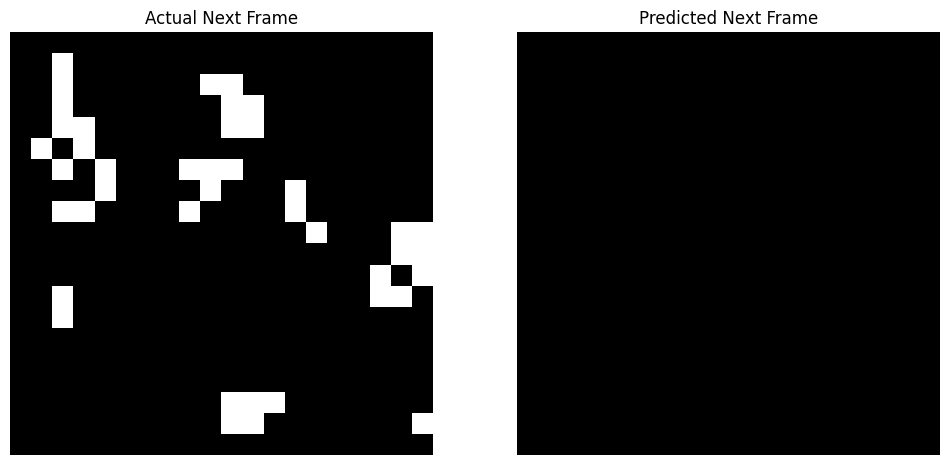

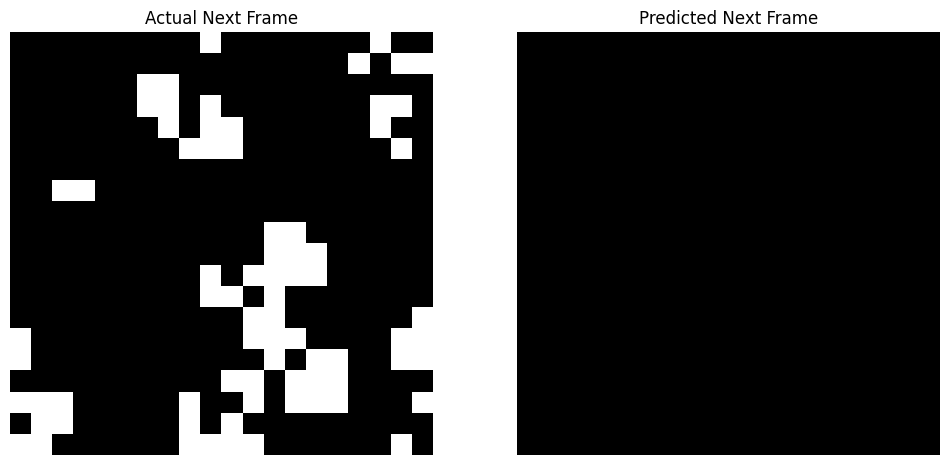

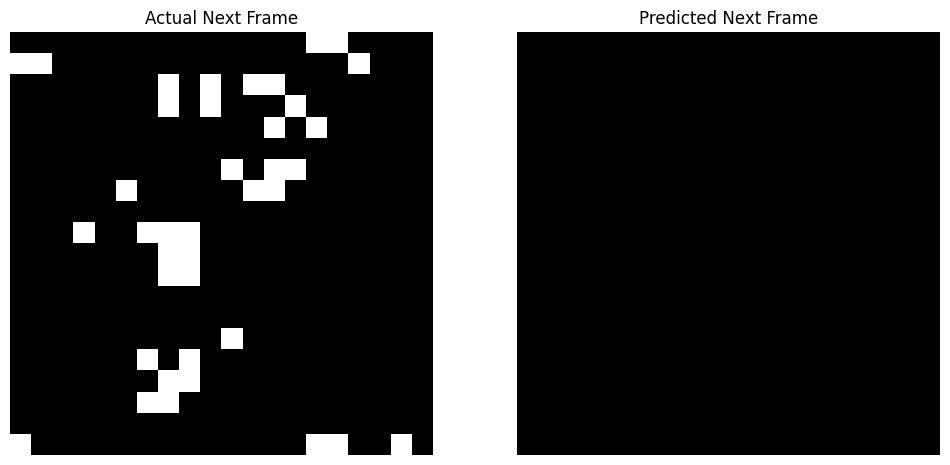

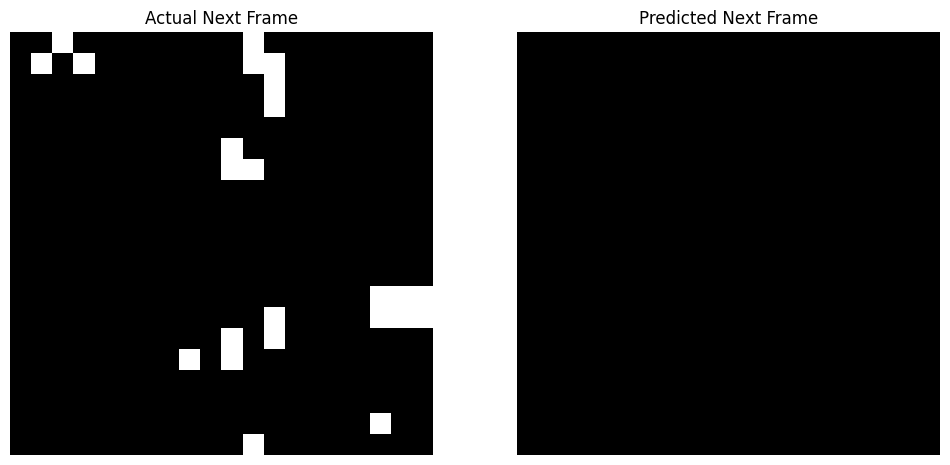

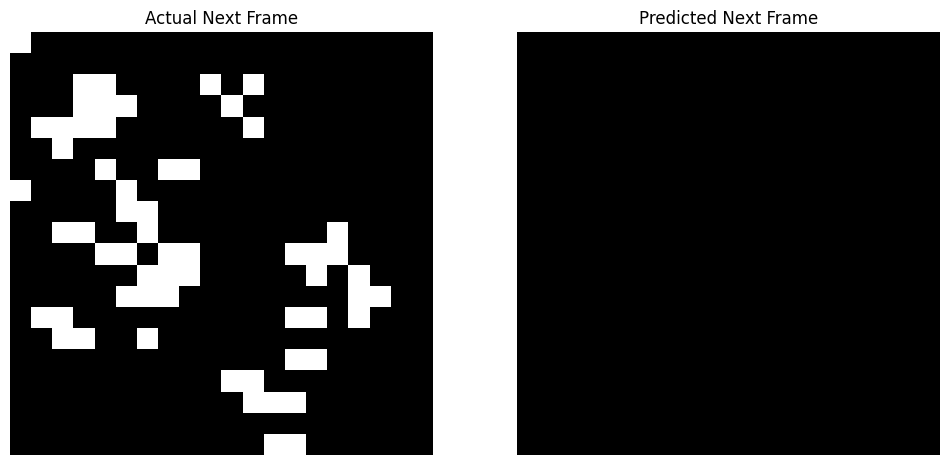

In [43]:
def manual_convolution(input_data, weights, bias):
    num_filters = weights.shape[0]
    filter_height = weights.shape[2]
    filter_width = weights.shape[3]
    padding_height = filter_height // 2
    padding_width = filter_width // 2

    batch_size, input_height, input_width, input_channels = input_data.shape

    # Apply padding to maintain the size after convolution
    padded_input = np.pad(input_data, ((0, 0), (padding_height, padding_height), (padding_width, padding_width), (0, 0)), mode='constant', constant_values=0)

    output_height = input_height
    output_width = input_width
    output = np.zeros((batch_size, output_height, output_width, num_filters))

    for b in range(batch_size):
        for f in range(num_filters):
            for c in range(input_channels):
                kernel_flipped = weights[f, c, ::-1, ::-1]
                # Ensuring output size is the same as input size using 'full' and cropping
                full_conv_output = convolve2d(padded_input[b, :, :, c], kernel_flipped, mode='full')
                start_index = (full_conv_output.shape[0] - output_height) // 2
                conv_output = full_conv_output[start_index:start_index + output_height, start_index:start_index + output_width]
                output[b, :, :, f] += conv_output
            output[b, :, :, f] += bias[f]

    return output[:, :, :, 0]  # Assume you want the first filter's output

X_test = X_test.astype(np.float32)  # Assuming X_test is your test data array

# Generate predictions
pred_classes = [manual_convolution(X_test[i:i+1], weights, bias) for i in range(len(X_test))]

# Apply threshold
def apply_threshold(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

pred_classes_binary = [apply_threshold(pred) for pred in pred_classes]

# Display the results
for i in range(min(5, len(X_test))):
    actual_board = y_test[i].reshape(board_shape)
    predicted_board = pred_classes_binary[i].reshape(board_shape)
    render_frames(actual_board, predicted_board)


In [49]:
# Debug: Print raw convolution output for the first few test cases
for i in range(min(5, len(X_test))):
    conv_output = manual_convolution(X_test[i:i+1], weights, bias)
    print(f"Raw output (sample {i}): Min={np.min(conv_output)}, Max={np.max(conv_output)}, Mean={np.mean(conv_output)}")

Raw output (sample 0): Min=-0.4358629807829857, Max=0.23632559925317764, Mean=0.0054942405596375464
Raw output (sample 1): Min=-0.45955999940633774, Max=0.29404399544000626, Mean=-0.007477294225245714
Raw output (sample 2): Min=-0.45955999940633774, Max=0.21241731196641922, Mean=0.01616119537502527
Raw output (sample 3): Min=-0.3897964581847191, Max=0.29404399544000626, Mean=0.014949056766927243
Raw output (sample 4): Min=-0.49784430116415024, Max=0.23632559925317764, Mean=-0.01336897324770689


In [46]:
# Adjust the threshold and see the effects
adjusted_threshold = 0.1  # Example of a lower threshold
pred_classes_binary = [apply_threshold(pred, threshold=adjusted_threshold) for pred in pred_classes]


In [47]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply sigmoid before thresholding
pred_classes_sigmoid = [sigmoid(pred) for pred in pred_classes]
pred_classes_binary = [apply_threshold(pred, threshold=0.5) for pred in pred_classes_sigmoid]


Debug info for sample 0: Min=0.39272717840574606, Max=0.5588079532629225


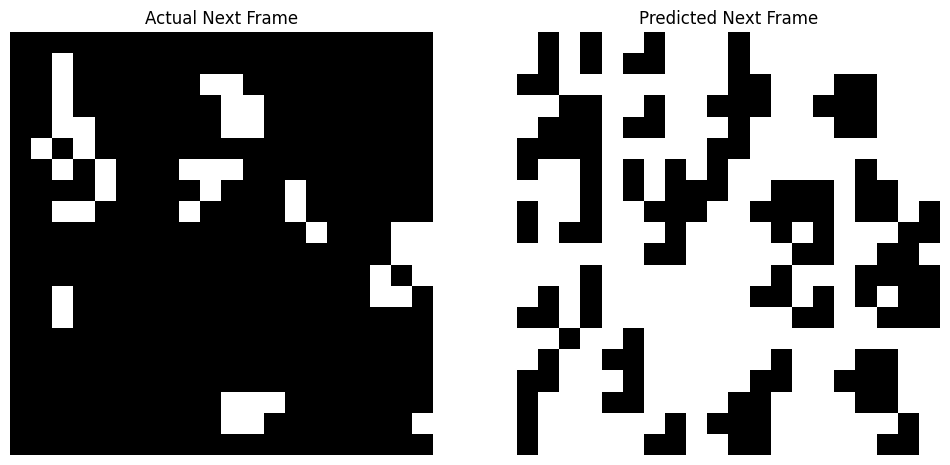

Debug info for sample 1: Min=0.387090209420758, Max=0.5729858804551733


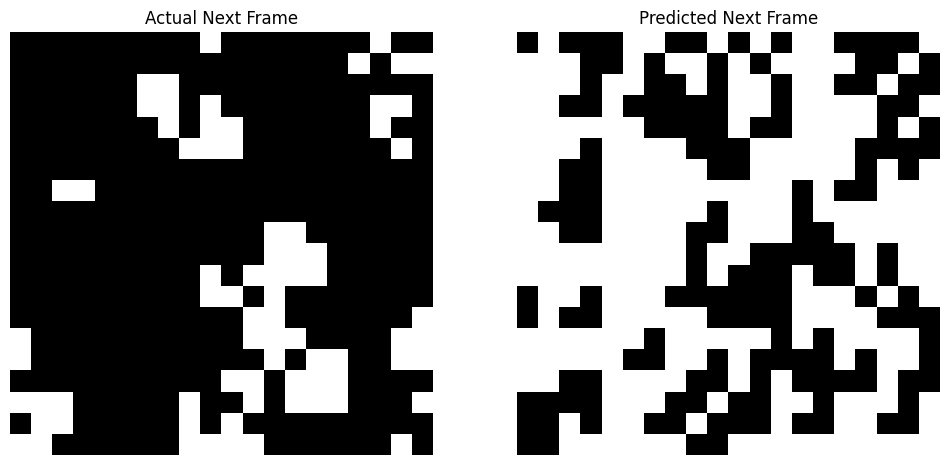

Debug info for sample 2: Min=0.387090209420758, Max=0.5529055476574981


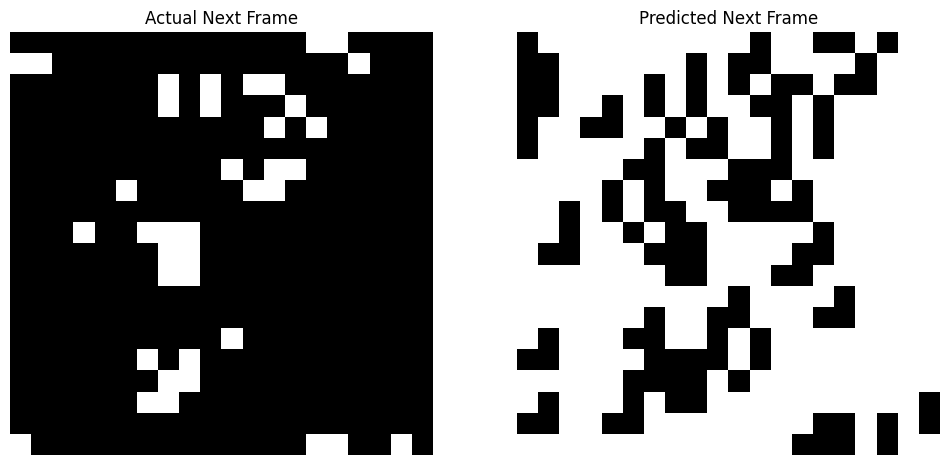

Debug info for sample 3: Min=0.40376630021160076, Max=0.5729858804551733


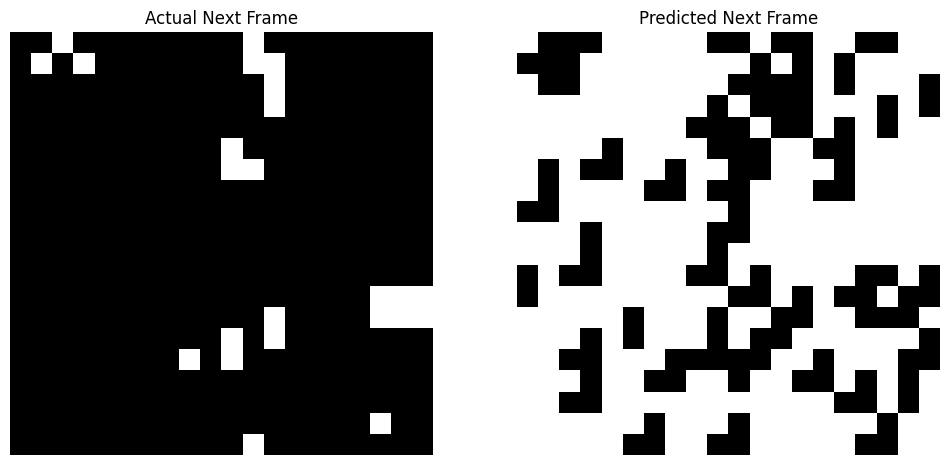

Debug info for sample 4: Min=0.37804739960027833, Max=0.5588079532629225


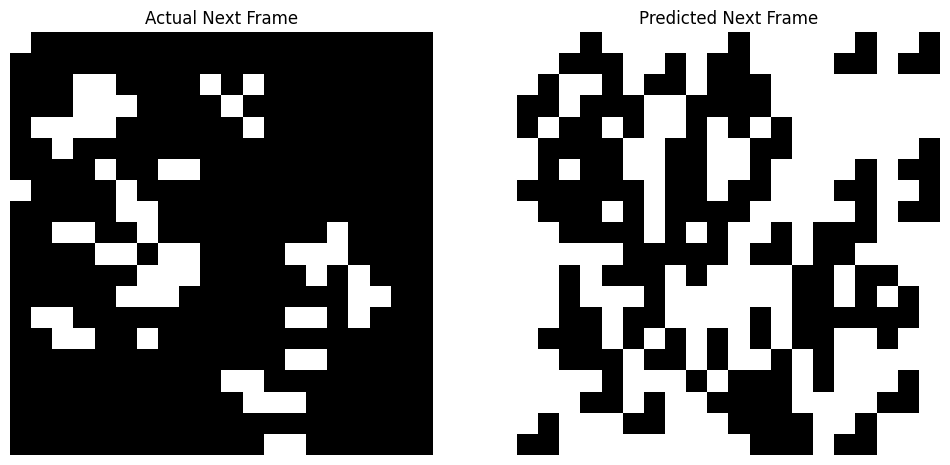

In [48]:
# Assuming all functions and imports are defined as previously

# Generate predictions and apply sigmoid if needed
pred_classes = [manual_convolution(X_test[i:i+1], weights, bias) for i in range(len(X_test))]
pred_classes_sigmoid = [sigmoid(pred) for pred in pred_classes]

# Adjust threshold and convert predictions to binary
pred_classes_binary = [apply_threshold(pred, threshold=0.5) for pred in pred_classes_sigmoid]

# Display the results with debugging info
for i in range(min(5, len(X_test))):
    actual_board = y_test[i].reshape(board_shape)
    predicted_board = pred_classes_binary[i].reshape(board_shape)
    print(f"Debug info for sample {i}: Min={np.min(pred_classes_sigmoid[i])}, Max={np.max(pred_classes_sigmoid[i])}")
    render_frames(actual_board, predicted_board)


**Simple Linear regression with onnx backend using operators**

In [1]:
import tensorflow as tf

# Define a simple linear model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

model.compile(optimizer='sgd', loss='mean_squared_error')
model.summary()

# Train the model with some example data (e.g., y = 2x + 1)
import numpy as np
x = np.array([-1.0, 0, 1, 2, 3, 4], dtype=float)
y = np.array([-1.0, 1, 3, 5, 7, 9], dtype=float)

model.fit(x, y, epochs=500, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
# !pip install tf2onnx

import tf2onnx

# Convert model to ONNX
input_signature = [tf.TensorSpec([None, 1], tf.float32, name='input')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)
with open("linear_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.4 MB/s eta 0:00:00


In [4]:
import onnx
import numpy as np

# Load ONNX model
onnx_model = onnx.load("linear_model.onnx")

# Extract model information
# Assume the model is very simple: just one linear layer
weights = onnx.numpy_helper.to_array(onnx_model.graph.initializer[0])
bias = onnx.numpy_helper.to_array(onnx_model.graph.initializer[1])

def run_onnx_backend(input_data):
    # Compute the linear transformation manually
    return np.dot(input_data, weights.T) + bias

# Test the backend with example data
input_data = np.array([[10]], dtype=np.float32)
output = run_onnx_backend(input_data)
print("Predicted output:", output)

Predicted output: [[20.999018]]


In [7]:
# !pip install -q netron
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('/content/linear_model.onnx', port, browse=False)

output.serve_kernel_port_as_iframe(port, height='800')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

**Simple CNN with onnx backend using operators**

In [5]:
import tensorflow as tf

# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')  # Assume 10 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with some example data (e.g., MNIST)
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255

model.fit(train_images, train_labels, epochs=5, verbose=2)  # Train for 5 epochs

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                27050     
                                                                 
Total params: 27210 (106.29 KB)
Trainable params: 27210 (106.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/18

In [8]:
import tf2onnx

# Convert model to ONNX
input_signature = [tf.TensorSpec([None, 28, 28, 1], tf.float32, name='input')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)
with open("simple_cnn.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [17]:
import onnx

# Load the ONNX model
model_path = 'simple_cnn.onnx'
model = onnx.load(model_path)

# List all initializers in the model
print("Listing all tensors (initializers) in the model:")
for tensor in model.graph.initializer:
    print(tensor.name, tensor.dims)

Listing all tensors (initializers) in the model:
sequential_1/dense_1/MatMul/ReadVariableOp:0 [2704, 10]
sequential_1/dense_1/BiasAdd/ReadVariableOp:0 [10]
sequential_1/conv2d/Conv2D/ReadVariableOp:0 [16, 1, 3, 3]
sequential_1/conv2d/BiasAdd/ReadVariableOp:0 [16]
new_shape__20 [4]
const_fold_opt__21 [2]


In [18]:
import onnx
import numpy as np
from onnx import numpy_helper

# Load the ONNX model
model_path = 'simple_cnn.onnx'
model = onnx.load(model_path)

# Initialize variables for weights and biases
weights = None
bias = None

# Extract weights and biases based on their names
for init in model.graph.initializer:
    if init.name == "sequential_1/conv2d/Conv2D/ReadVariableOp:0":
        weights = numpy_helper.to_array(init)
    elif init.name == "sequential_1/conv2d/BiasAdd/ReadVariableOp:0":
        bias = numpy_helper.to_array(init)

# Verify if weights and biases have been loaded
if weights is not None and bias is not None:
    print("Weights loaded successfully, shape:", weights.shape)
    print("Bias loaded successfully, shape:", bias.shape)
else:
    print("Failed to load weights and/or bias.")

Weights loaded successfully, shape: (16, 1, 3, 3)
Bias loaded successfully, shape: (16,)


In [20]:
import numpy as np
from scipy.signal import convolve2d

def manual_convolution(input_data, weights, bias):
    num_filters = weights.shape[0]
    filter_height = weights.shape[2]
    filter_width = weights.shape[3]

    batch_size, in_height, in_width, in_channels = input_data.shape

    # Calculate output dimensions
    output_height = in_height - filter_height + 1
    output_width = in_width - filter_width + 1

    # Initialize output array
    output = np.zeros((batch_size, output_height, output_width, num_filters))

    for b in range(batch_size):  # Loop over each image in the batch
        for f in range(num_filters):  # Loop over each filter
            for c in range(in_channels):  # Loop over each channel in the input image
                # Flip the kernel for convolution
                kernel_flipped = weights[f, c, ::-1, ::-1]
                # Perform convolution
                output[b, :, :, f] += convolve2d(input_data[b, :, :, c], kernel_flipped, mode='valid')
            # Add bias to each output feature map
            output[b, :, :, f] += bias[f]

    return output

# Example input data: 1 image of 28x28 pixels with 1 channel
input_data = np.random.rand(1, 28, 28, 1).astype(np.float32)

# Perform the convolution using the loaded weights and bias
output = manual_convolution(input_data, weights, bias)
print("Output shape:", output.shape)
print("Sample output data (first feature map of the first image):", output[0, :, :, 0])

Output shape: (1, 26, 26, 16)
Sample output data (first feature map of the first image): [[ 9.05715823e-02 -2.12989293e-01 -3.18265595e-01  9.51403677e-02
  -1.96818084e-01 -1.52411133e-01 -3.02638672e-01 -2.05000333e-01
   1.42135918e-01 -1.48340434e-01  1.46572024e-01 -6.19918108e-04
   2.38692760e-03  3.02941561e-01  3.98412943e-02 -3.05842530e-01
  -1.26982108e-01  3.91951382e-01 -1.56050533e-01 -2.04448164e-01
  -9.00793076e-03  2.17152655e-01 -1.17603153e-01  1.47543162e-01
   2.06759632e-01 -4.21393812e-02]
 [-8.57260823e-03 -3.55904151e-01 -2.89683132e-01 -5.59804142e-02
   1.28394932e-01  9.93876457e-02  2.97899306e-01  1.48979425e-02
  -4.46240187e-01 -8.70737433e-02  6.37779236e-01  2.12281108e-01
   1.41203552e-01  1.29001141e-01 -1.07787564e-01 -2.80707151e-01
  -1.28656417e-01  1.51229084e-01 -3.89683448e-01 -3.03893849e-01
   1.75491571e-02 -6.89866990e-02  1.56892240e-02  1.72216296e-02
  -1.25268325e-01 -9.77045298e-02]
 [ 2.11118460e-01  2.02155292e-01 -1.57656431e-01

In [21]:
# !pip install -q netron
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('/content/simple_cnn.onnx', port, browse=False)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import tf2onnx
import onnx
from onnx import numpy_helper

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, verbose=2)

# Convert model to ONNX
input_signature = [tf.TensorSpec([None, 28, 28, 1], tf.float32, name='input')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)
with open("simple_cnn.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [23]:
import onnx

# Load the ONNX model
model_path = 'simple_cnn.onnx'
model = onnx.load(model_path)

# Print all initializers (weights and biases usually reside here)
print("Initializers in the ONNX model:")
for init in model.graph.initializer:
    print(init.name)


Initializers in the ONNX model:
sequential_2/dense_2/MatMul/ReadVariableOp:0
sequential_2/dense_2/BiasAdd/ReadVariableOp:0
sequential_2/conv2d_1/Conv2D/ReadVariableOp:0
sequential_2/conv2d_1/BiasAdd/ReadVariableOp:0
new_shape__36
const_fold_opt__37


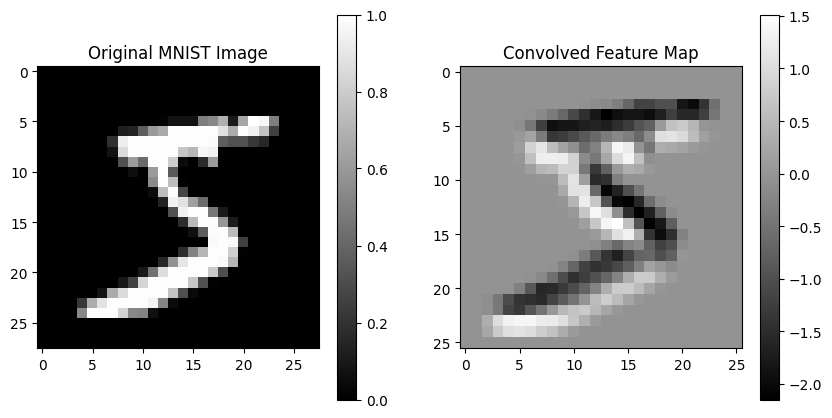

In [25]:
import onnx
from onnx import numpy_helper

# Load the ONNX model
model_path = 'simple_cnn.onnx'
model = onnx.load(model_path)

# Initialize variables for weights and biases
weights = None
bias = None

# Extract weights and biases based on their names
for init in model.graph.initializer:
    if init.name == "sequential_2/conv2d_1/Conv2D/ReadVariableOp:0":
        weights = numpy_helper.to_array(init)
    elif init.name == "sequential_2/conv2d_1/BiasAdd/ReadVariableOp:0":
        bias = numpy_helper.to_array(init)

# Ensure weights and biases were loaded
assert weights is not None and bias is not None, "Failed to load weights and/or bias."

# Now you can proceed with any operations that use these weights and biases

# Manual convolution function
def manual_convolution(input_data, weights, bias):
    num_filters = weights.shape[0]
    filter_height = weights.shape[2]
    filter_width = weights.shape[3]
    batch_size, in_height, in_width, in_channels = input_data.shape
    output_height = in_height - filter_height + 1
    output_width = in_width - filter_width + 1
    output = np.zeros((batch_size, output_height, output_width, num_filters))
    for b in range(batch_size):
        for f in range(num_filters):
            for c in range(in_channels):
                kernel_flipped = weights[f, c, ::-1, ::-1]
                output[b, :, :, f] += convolve2d(input_data[b, :, :, c], kernel_flipped, mode='valid')
            output[b, :, :, f] += bias[f]
    return output

# Load and preprocess a specific MNIST image
input_image = train_images[0:1]  # Use the first image from the training set

# Perform the convolution
output = manual_convolution(input_image, weights, bias)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original MNIST Image')
plt.imshow(input_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Convolved Feature Map')
plt.imshow(output[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.grid(False)

plt.show()

In [52]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('/content/simple_cnn.onnx', port, browse=False)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>